<a href="https://colab.research.google.com/github/otokwala/Common-features/blob/main/LSTM_Autoencoder_code_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, scale
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
from numpy.random import seed
import tensorflow as tf
tf.random.set_seed(10)
import keras
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model, load_model, Sequential
from keras import regularizers
import csv
from google.colab import files

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data=pd.read_csv(r'/content/drive/MyDrive/Datasets/All_Autoencoder_Data.csv')

In [5]:
Labels=data['Labels'].tolist()

In [6]:
data1 = data.drop('Labels', axis=1)

In [7]:
data1.shape

(225711, 68)

In [8]:
def create_sequences(X, time_steps=5):
    Xs = []
    for i in range(0, len(X)-time_steps, 1):
        Xs.append(X.iloc[i:(i+time_steps)].values)
    
    return np.array(Xs)

In [9]:
X_train=create_sequences(data1)
X_train.shape

(225706, 5, 68)

In [10]:
# define the autoencoder network model
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
eL0 = LSTM(64, activation='tanh', return_sequences=True,
            recurrent_activation="sigmoid", 
            kernel_initializer="glorot_uniform",
            recurrent_regularizer=regularizers.l2(0.001), 
            kernel_regularizer=regularizers.l2(0.001))(inputs)

eL1 = LSTM(32, activation='tanh', return_sequences=True,
            recurrent_activation="sigmoid", 
            kernel_initializer="glorot_uniform",
            recurrent_regularizer=regularizers.l2(0.001), 
            kernel_regularizer=regularizers.l2(0.001))(eL0)

eL2 = LSTM(16, activation='tanh', return_sequences=True,
            recurrent_activation="sigmoid",  
            kernel_initializer="glorot_uniform", 
            recurrent_regularizer=regularizers.l2(0.001), 
            kernel_regularizer=regularizers.l2(0.001))(eL1)

eL3 = LSTM(5, activation='tanh', return_sequences=False)(eL2)
#     eL3 = LSTM(16, activation='relu', return_sequences=False)(eL2)
h = RepeatVector(X_train.shape[1])(eL3)

dL2 = LSTM(16, activation='tanh', return_sequences=True)(h)

dL3 = LSTM(32, activation='tanh', return_sequences=True)(dL2)

dL4 = LSTM(64, activation='tanh', return_sequences=True)(dL3)

output = TimeDistributed(Dense(X_train.shape[2]))(dL4)    
#output = Dense(X_train.shape[2])(dL4)  
model = Model(inputs=inputs, outputs=output)
#return model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 68)]           0         
                                                                 
 lstm (LSTM)                 (None, 5, 64)             34048     
                                                                 
 lstm_1 (LSTM)               (None, 5, 32)             12416     
                                                                 
 lstm_2 (LSTM)               (None, 5, 16)             3136      
                                                                 
 lstm_3 (LSTM)               (None, 5)                 440       
                                                                 
 repeat_vector (RepeatVector  (None, 5, 5)             0         
 )                                                               
                                                             

Epoch 1/400
632/632 [==============================] - 25s 21ms/step - loss: 0.0616 - accuracy: 0.5130 - val_loss: 0.0869 - val_accuracy: 0.4697
Epoch 2/400
632/632 [==============================] - 10s 16ms/step - loss: 0.0607 - accuracy: 0.5166 - val_loss: 0.0859 - val_accuracy: 0.4676
Epoch 3/400
632/632 [==============================] - 9s 14ms/step - loss: 0.0613 - accuracy: 0.5139 - val_loss: 0.0911 - val_accuracy: 0.4675
Epoch 4/400
632/632 [==============================] - 10s 15ms/step - loss: 0.0609 - accuracy: 0.5162 - val_loss: 0.0878 - val_accuracy: 0.4614
Epoch 5/400
632/632 [==============================] - 10s 17ms/step - loss: 0.0607 - accuracy: 0.5161 - val_loss: 0.0886 - val_accuracy: 0.4706
Epoch 6/400
632/632 [==============================] - 9s 14ms/step - loss: 0.0612 - accuracy: 0.5163 - val_loss: 0.0868 - val_accuracy: 0.4704
Epoch 7/400
632/632 [==============================] - 10s 15ms/step - loss: 0.0607 - accuracy: 0.5193 - val_loss: 0.0866 - val_accu

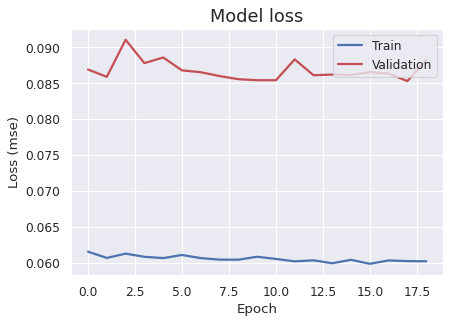

In [14]:
# fit the model to the data
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
nb_epochs = 400
batch_size = 250
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='log_cosh', metrics=['accuracy'])

history = model.fit(X_train, X_train, 
                    epochs=nb_epochs, 
                    batch_size=batch_size,
                    validation_split=0.3, 
                    callbacks=[callback]
                    ).history



# plot the training losses
fig, ax = plt.subplots(figsize=(6, 4), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mse)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/PFP/Figures/GRU_AE_50K.pdf')
plt.show()

In [15]:
encode = Model(inputs=inputs, outputs=model.layers[5].output)
output_encoder = encode.predict(X_train[:])

7054/7054 [==============================] - 25s 3ms/step


In [16]:
len(output_encoder)

225706

In [ ]:
#output_encoder[1][1].tolist()

In [17]:
outputs =[]
for i in output_encoder:
    arr = i[4].tolist()
    outputs.append(arr)


In [18]:
len(outputs)

225706

In [19]:
from google.colab import files
df = pd.DataFrame(outputs)

In [22]:
del Labels[-5:]

In [23]:
len(Labels)

225706

In [26]:
#append list to encoded data
df['Labels']=Labels

In [29]:
df.shape

(225706, 6)

In [31]:
encoded=df

In [32]:
encoded.columns=['V1','V2','V3','V4','V5','Labels']

In [36]:
encoded['Labels'].value_counts()

1    128025
0     97681
Name: Labels, dtype: int64

In [30]:
# save the DataFrame to a CSV file
df.to_csv('df.csv', index=False, header=False)
files.download('df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>